## Predicted ionospheric range delay (for different SAR bands and range bandwidths)

In [1]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt, ticker
from mintpy.simulation import iono
plt.rcParams.update({'font.size': 12})

work_dir = os.path.expanduser('~/Papers/2022_GeolocRg/figs_src/iono')
os.chdir(work_dir)
print('Go to directory:', work_dir)

Go to directory: /Users/yunjunz/Papers/2022_GeolocRg/figs_src/iono


In [2]:
# constants
K = 40.31
Re = 6371e3   # earth radius in meters
speed_of_light = 299792458 # speed of light in m / s

# SAR parameters
bnames = ['L', 'S', 'C', 'X']
freqs = [1.257e9, 3.2e9, 5.405e9, 9.65e9]  #carrier frequency for NISAR-L/-S, S1 and TSX
rg_bandwidths = [24e6, 44e6, 80e6]         #range bandwidth (sampling frequency) in Hz
inc_angle = 42                             #LOS incidence angle on the ground in deg
height = 747e3                             #NISAR altitude in meters

inc_angle_iono = iono.incidence_angle_ground2iono(inc_angle)
print('center incidence angle on the ground    : {:.1f} deg'.format(inc_angle))
print('center incidence angle on the ionosphere: {:.1f} deg'.format(inc_angle_iono))

# Numbers for 20 TECU
VTEC = 10

# geocoding
print('-'*50)
rg_delays = [iono.vtec2range_delay(VTEC, inc_angle_iono, freq) for freq in freqs]
for rg_delay, bname in zip(rg_delays, bnames):
    times = rg_delays[0] / rg_delay
    print(f'{VTEC} TECU -> {rg_delay:.1f} m for {bname}-band (1 / {times:.1f} of L-band).')

# coregistration at L-band
print('-'*50)
for rg_bw in [24e6, 44e6, 80e6]:
    rg_delay_pix = rg_delays[0] / (speed_of_light / rg_bw / 2)
    print(f'{VTEC} TECU -> {rg_delay_pix:.1f} pixels for L-band.')

# coregistration at S-/C-/X-bands (NISAR-S, S1 and TSX)
print('-'*50)
for rg_delay, bname, rg_bw in zip(rg_delays[1:], bnames[1:], [75e6, 64.35e6, 109.89e6]):
    rg_delay_pix = rg_delay / (speed_of_light / rg_bw / 2)
    print(f'{VTEC} TECU -> {rg_delay_pix:.2f} pixels for {bname}-band with range bandwidth of {rg_bw/1e6} MHz.')

center incidence angle on the ground    : 42.0 deg
center incidence angle on the ionosphere: 38.7 deg
--------------------------------------------------
10 TECU -> 2.6 m for L-band (1 / 1.0 of L-band).
10 TECU -> 0.4 m for S-band (1 / 5.9 of L-band).
10 TECU -> 0.2 m for C-band (1 / 15.7 of L-band).
10 TECU -> 0.1 m for X-band (1 / 47.9 of L-band).
--------------------------------------------------
10 TECU -> 0.4 pixels for L-band.
10 TECU -> 0.8 pixels for L-band.
10 TECU -> 1.4 pixels for L-band.
--------------------------------------------------
10 TECU -> 0.22 pixels for S-band with range bandwidth of 75.0 MHz.
10 TECU -> 0.07 pixels for C-band with range bandwidth of 64.35 MHz.
10 TECU -> 0.04 pixels for X-band with range bandwidth of 109.89 MHz.


## Plot

save figure to file /Users/yunjunz/Papers/2022_GeolocRg/figs_src/iono/iono2delay.pdf


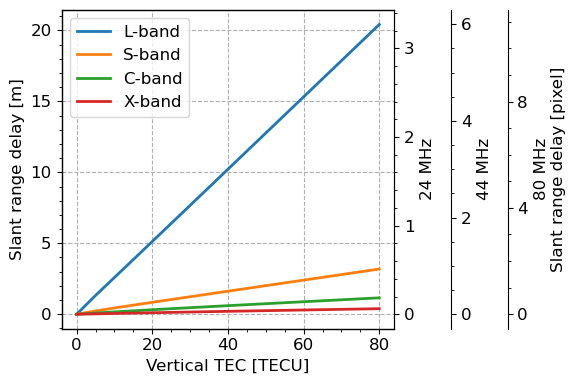

In [3]:
TEC = np.linspace(0, 80, 17)          #iono in TECU

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6.5, 4])
## range delay in meters
for i, (bname, freq, mfc) in enumerate(zip(bnames, freqs, ['C0', 'C1', 'C2', 'C3'])):
    rg_delay_m = iono.vtec2range_delay(TEC, inc_angle_iono, freq)
    ax.plot(TEC, rg_delay_m, '-', color=mfc, lw=2, label='{}-band'.format(bname))
# axis format
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5));  ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_xlabel('Vertical TEC [TECU]')
ax.set_ylabel('Slant range delay [m]')
ax.legend()
ax.grid('on', linestyle='--')

## range delay in pixels
for i, (rg_bandwidth, ystep) in enumerate(zip(rg_bandwidths, [1, 2, 4])):
    # add y-axis
    ax2 = ax.twinx()
    ax2.spines['right'].set_position(('axes', 1.0+0.17*i))
    ax2.tick_params(which='both', axis='y')
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(ystep))
    ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    # ylabel
    label = '{:.0f} MHz'.format(rg_bandwidth/1e6)
    label += '\nSlant range delay [pixel]' if i == len(rg_bandwidths) - 1 else ''
    ax2.set_ylabel(label)
    # ylim sync btw. ax and ax2
    rg_pixel_size = speed_of_light / rg_bandwidth / 2
    ax2.set_ylim(np.array(ax.get_ylim()) / rg_pixel_size)
fig.tight_layout()

# output
out_fig = os.path.join(work_dir, 'iono2delay.pdf')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### Ionospheric Sensitivity between L/S/C/X-band SAR

In [4]:
vtec = np.linspace(0, 100, 1000*5)[1:]
rg_delay_L = iono.vtec2range_delay(vtec, inc_angle_iono, freqs[0])
rg_delay_S = iono.vtec2range_delay(vtec, inc_angle_iono, freqs[1])
rg_delay_C = iono.vtec2range_delay(vtec, inc_angle_iono, freqs[2])
rg_delay_X = iono.vtec2range_delay(vtec, inc_angle_iono, freqs[3])
sen_LS = rg_delay_L / rg_delay_S
sen_LC = rg_delay_L / rg_delay_C
sen_LX = rg_delay_L / rg_delay_X
print('VTEC range: {:.0f} - {:.0f} TECU'.format(min(vtec), max(vtec)))
print('Sensitivity bwt. L / S band: {:.0f} ({:4.1f} - {:4.1f})'.format(np.median(sen_LS), min(sen_LS), max(sen_LS)))
print('Sensitivity bwt. L / C band: {:.0f} ({:4.1f} - {:4.1f})'.format(np.median(sen_LC), min(sen_LC), max(sen_LC)))
print('Sensitivity bwt. L / X band: {:.0f} ({:4.1f} - {:4.1f})'.format(np.median(sen_LX), min(sen_LX), max(sen_LX)))

VTEC range: 0 - 100 TECU
Sensitivity bwt. L / S band: 6 ( 5.7 -  6.5)
Sensitivity bwt. L / C band: 17 (15.6 - 18.4)
Sensitivity bwt. L / X band: 51 (47.9 - 58.7)


save figure to file /Users/yunjunz/Papers/2022_GeolocRg/figs_src/iono/iono_sen.pdf


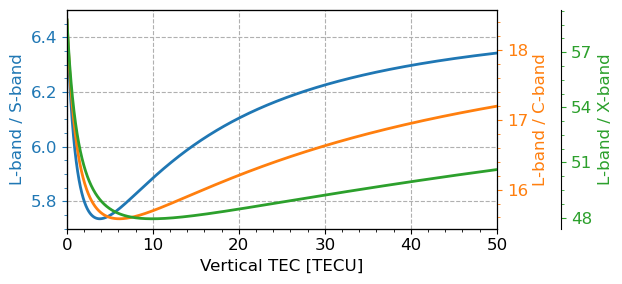

In [5]:
fig, ax1 = plt.subplots(figsize=[6.5, 3])
ax2 = ax1.twinx();  ax2.spines['right'].set_position(('axes', 1.00));  ax2.tick_params(which='both', axis='y')
ax3 = ax1.twinx();  ax3.spines['right'].set_position(('axes', 1.15));  ax3.tick_params(which='both', axis='y')
ysteps = [0.2, 1, 3]
cs = ['C0', 'C1', 'C2']
for ax, sen, c, ystep in zip([ax1, ax2, ax3], [sen_LS, sen_LC, sen_LX], cs, ysteps):
    ax.plot(vtec, sen, color=c, lw=2)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(ystep))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
# axis formata
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.tick_params(which='both', axis='y', colors=cs[0]);  ax1.set_ylabel('L-band / S-band', color=cs[0])
ax2.tick_params(which='both', axis='y', colors=cs[1]);  ax2.set_ylabel('L-band / C-band', color=cs[1])
ax3.tick_params(which='both', axis='y', colors=cs[2]);  ax3.set_ylabel('L-band / X-band', color=cs[2])
ax1.set_xlabel('Vertical TEC [TECU]')
ax1.grid('on', linestyle='--')
ax1.set_xlim(0, 50)
fig.tight_layout()

# output
out_fig = os.path.join(work_dir, 'iono_sen.pdf')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()